In [1]:
import os
import torch
import datasets.paths as d_path
import torchvision

from utils.init import reproducibility, clean_memory_get_device
from config import ConfigArgs
from utils.train import EarlyStopper, TrainingInfo, epoch_end_print, get_dataloaders, get_datasets, check_best, end_train, evaluate, train_one_epoch
from torchvision.models import resnet50, ResNet50_Weights
from utils.plot import plot_losses
from IPython.display import clear_output
from datasets.reflacx.chexpert import REFLACXCheXpertDataset
from datasets.reflacx.lesion_detection import REFLACXLesionDetectionDataset
from engine.classification import ClassificationEvaluator, load_cl_pretrained, resnet_set_trainable_layers
from models.classification import MultiBinaryClassificationModel

import warnings
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
device = clean_memory_get_device()
# device = torch.device("cpu")
reproducibility()
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

In [3]:
from config.dataset import REFLACXCheXpertDatasetArgs
from config.model import ResNetClassifierArgs
from config.training import ImageClassificationArgs

training_args = ImageClassificationArgs(
    name="chexpert",
)
dataset_args = REFLACXCheXpertDatasetArgs(
    image_size=128,
)
cl_model_name = "MCL_resnet50_accuracy_0_0600_epoch1_10-03-2023 00-10-45"


configs = [
    ConfigArgs(
        training=training_args,
        dataset=dataset_args,
        model=ResNetClassifierArgs(
            name="CL_NoFix",
            weights="cl",
            cl_model_name=cl_model_name,
            trainable_backbone_layers=5,
        )
    ),
    ConfigArgs(
        training=training_args,
        dataset=dataset_args,
        model=ResNetClassifierArgs(
            name="CL_Fix0",
            weights="cl",
            cl_model_name=cl_model_name,
            trainable_backbone_layers=0,
        )
    ),
    ConfigArgs(
        training=training_args,
        dataset=dataset_args,
        model=ResNetClassifierArgs(
            name="CL_Fix2",
            weights="cl",
            cl_model_name=cl_model_name,
            trainable_backbone_layers=3,
        )
    ),
    ConfigArgs(
        training=training_args,
        dataset=dataset_args,
        model=ResNetClassifierArgs(
            name="imagenet",
            weights="imagenet",
            trainable_backbone_layers=3,
        )
    ),
    ConfigArgs(
        training=training_args,
        dataset=dataset_args,
        model=ResNetClassifierArgs(
            name="random",
            weights=None,
            trainable_backbone_layers=5,
        )
    ),
]

In [4]:
num_epochs = 5 # 200
train_infos: list[TrainingInfo] = []

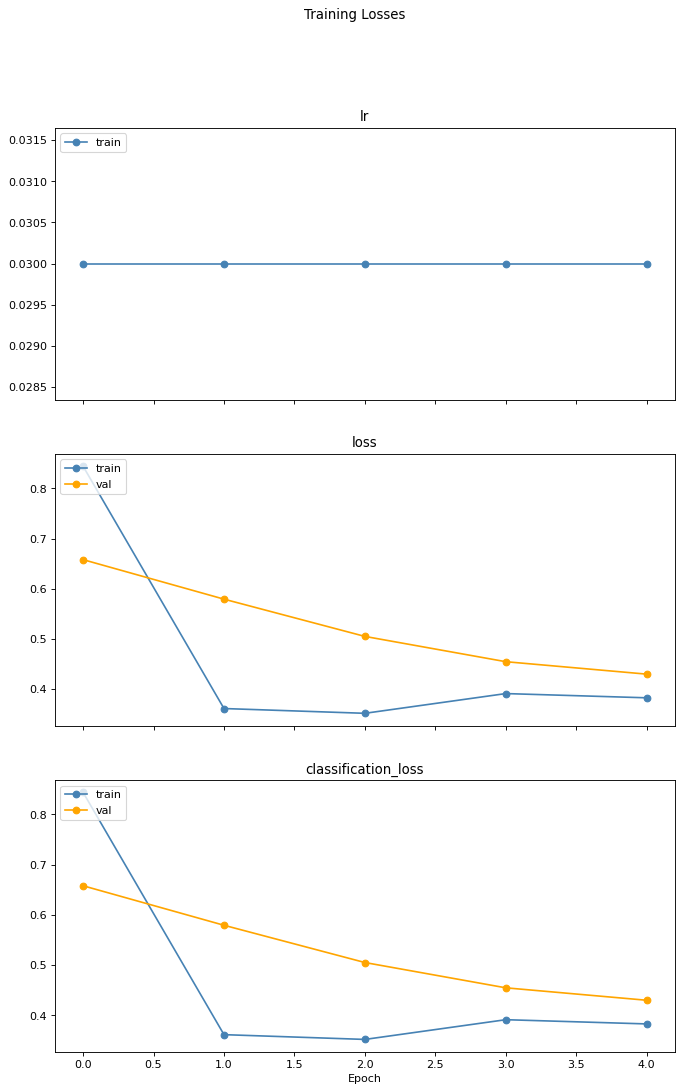

| Epoch [5] Done | It has took [0.61] min, Avg time: [7.32] sec/epoch | Estimate time for [5] epochs: [0.61] min | Epoch took [7.250111] sec |  Patience [0] |
Previous model: [chexpert_random_f1_0_0000_precision_0_0000_accuracy_0_8529_recall_0_0000_auc_0_5000_epoch4_10-03-2023 02-49-10] has been remove!!
| Training Done, start testing! | [5] Epochs Training time: [36.644762] seconds, Avg time / Epoch: [7.3289524] seconds
========================================For Training [chexpert]========================================
ImageClassificationArgs(name='chexpert', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, early_stopping_patience=10, warmup_epoch=0)
REFLACXCheXpertDatasetArgs(image_size=128, label_cols=['Atelectasis_chexpert', 'Cardiomegaly_chexpert', 'Consolidation_chexpert', 'Edema_chexpert', 'Enlarged Cardiomediastinum_chexpert', 'Fracture_chexpert', 'Lung Lesion_chexpert', 'Lung Opacity_chexpert', 'No Finding_chexpert', 'Pleural Effusion_chexpert', 'P

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
for config in configs:
    # device = clean_memory_get_device()
    # reproducibility()

    train_info = TrainingInfo(config)

    if config.model.weights == 'imagenet':
        weights = ResNet50_Weights.IMAGENET1K_V2
    else:
        weights = None

    backbone = resnet50(weights=weights)
    model = MultiBinaryClassificationModel(backbone)
    model.to(device)
    # load CL weights.

    if config.model.weights == 'cl':
        model = load_cl_pretrained(
            model,
            config.model.cl_model_name,
        )

    model = resnet_set_trainable_layers(
        model, config.model.trainable_backbone_layers)
    
    model.setup_last_layer(len(config.dataset.label_cols))

    dataset_args = {
        "df_path": os.path.join('spreadsheets', "reflacx.csv"),
        "mimic_eye_path": d_path.MIMIC_EYE_PATH,
        "image_size": config.dataset.image_size,
        "label_cols": config.dataset.label_cols,
    }

    train_dataset, val_dataset, _ = get_datasets(
        dataset_args=dataset_args,
        dataset_class=REFLACXCheXpertDataset,
    )

    train_dataloader, val_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        batch_size=config.training.batch_size,
        drop_last=False,
    )

    optimiser = torch.optim.SGD(
        params=[p for p in model.parameters() if p.requires_grad],
        lr=config.training.learning_rate,
        momentum=config.training.sgd_momentum,
        weight_decay=config.training.weight_decay,
    )

    early_stopper = None
    if config.training.early_stopping_patience:
        early_stopper = EarlyStopper(
            patience=config.training.early_stopping_patience)

    train_info.timer.start_training()

    for e in range(1, num_epochs + 1):
        train_info.epoch = e
        train_info.timer.start_epoch()

        train_logger = train_one_epoch(
            model=model,
            optimiser=optimiser,
            data_loader=train_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
        )

        train_info.train_losses.append(train_logger.get_data())

        model.eval()

        val_logger, val_evaluator = evaluate(
            model=model,
            data_loader=val_dataloader,
            device=device,
            evaluator=ClassificationEvaluator(),
        )

        train_info.val_losses.append(val_logger.get_data())

        clear_output()
        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
        )
        epoch_end_print(train_info, early_stopper, num_epochs)

        if early_stopper and train_info.epoch > config.training.warmup_epoch:
            train_info = check_best(
                train_info=train_info,
                model=model,
                optimiser=optimiser,
                val_evaluator=val_evaluator,
            )
            to_stop = early_stopper.early_stop(
                train_info.val_losses[-1]['loss'])
            if to_stop:
                print(
                    f"| Patience reached [{early_stopper.counter}], EarlyStopping end |")
                break

    train_info = end_train(
        train_info=train_info,
        model=model,
        optimiser=optimiser,
        val_evaluator=val_evaluator,
    )

    train_infos.append(train_info)

========================================For Training [chexpert]========================================
ImageClassificationArgs(name='chexpert', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, early_stopping_patience=10, warmup_epoch=0)
REFLACXCheXpertDatasetArgs(image_size=128, label_cols=['Atelectasis_chexpert', 'Cardiomegaly_chexpert', 'Consolidation_chexpert', 'Edema_chexpert', 'Enlarged Cardiomediastinum_chexpert', 'Fracture_chexpert', 'Lung Lesion_chexpert', 'Lung Opacity_chexpert', 'No Finding_chexpert', 'Pleural Effusion_chexpert', 'Pleural Other_chexpert', 'Pneumonia_chexpert', 'Pneumothorax_chexpert', 'Support Devices_chexpert'])
ResNetClassifierArgs(name='CL_NoFix', weights='cl', cl_model_name='MCL_resnet50_accuracy_0_0600_epoch1_10-03-2023 00-10-45', trainable_backbone_layers=5)

Best model has been saved to: [chexpert_CL_NoFix_f1_0_0000_precision_0_0000_accuracy_0_8471_recall_0_0000_auc_0_4966_epoch5_10-03-2023 02-46-49]
The final model has been 

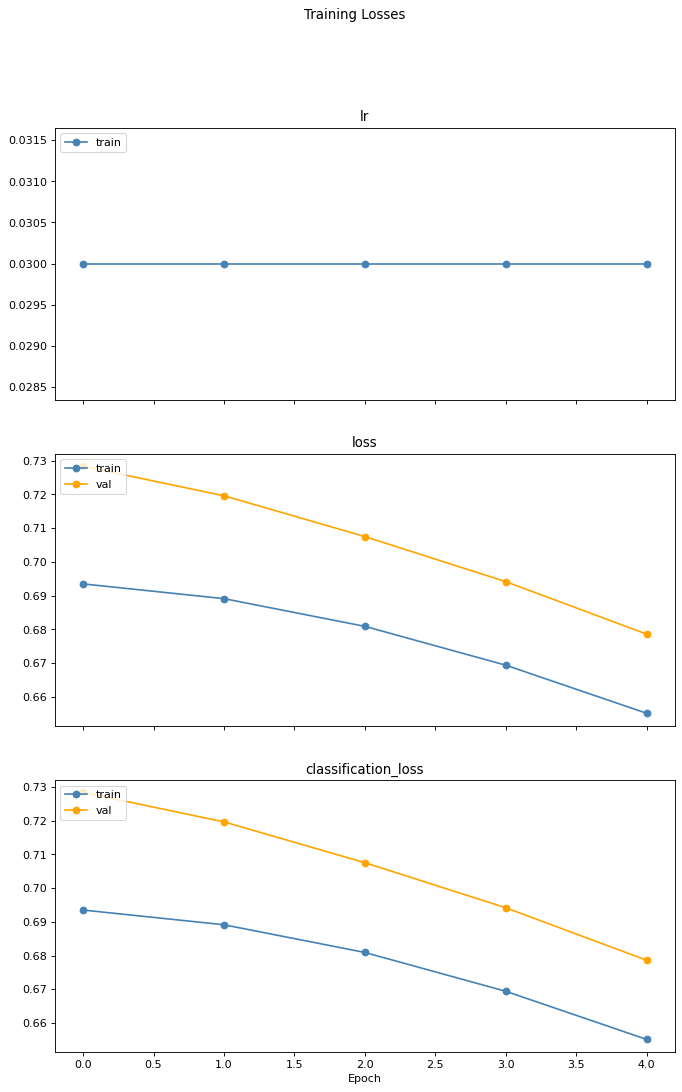

========================================For Training [chexpert]========================================
ImageClassificationArgs(name='chexpert', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, early_stopping_patience=10, warmup_epoch=0)
REFLACXCheXpertDatasetArgs(image_size=128, label_cols=['Atelectasis_chexpert', 'Cardiomegaly_chexpert', 'Consolidation_chexpert', 'Edema_chexpert', 'Enlarged Cardiomediastinum_chexpert', 'Fracture_chexpert', 'Lung Lesion_chexpert', 'Lung Opacity_chexpert', 'No Finding_chexpert', 'Pleural Effusion_chexpert', 'Pleural Other_chexpert', 'Pneumonia_chexpert', 'Pneumothorax_chexpert', 'Support Devices_chexpert'])
ResNetClassifierArgs(name='CL_Fix0', weights='cl', cl_model_name='MCL_resnet50_accuracy_0_0600_epoch1_10-03-2023 00-10-45', trainable_backbone_layers=0)

Best model has been saved to: [chexpert_CL_Fix0_f1_0_0000_precision_0_0000_accuracy_0_8529_recall_0_0000_auc_0_5000_epoch5_10-03-2023 02-47-27]
The final model has been sa

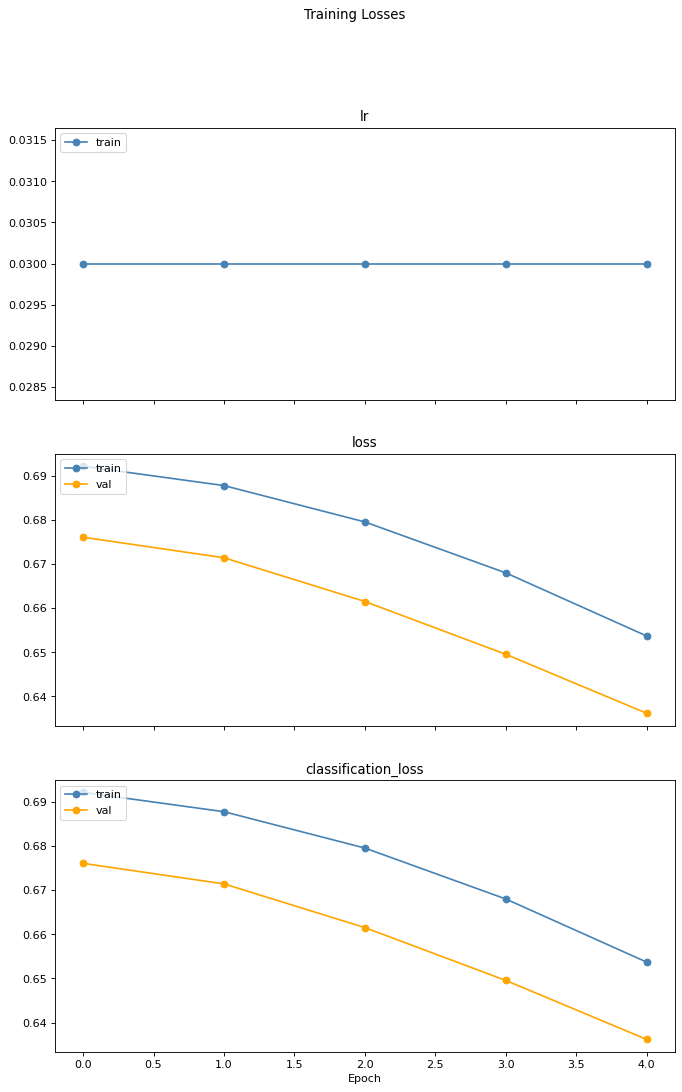

========================================For Training [chexpert]========================================
ImageClassificationArgs(name='chexpert', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, early_stopping_patience=10, warmup_epoch=0)
REFLACXCheXpertDatasetArgs(image_size=128, label_cols=['Atelectasis_chexpert', 'Cardiomegaly_chexpert', 'Consolidation_chexpert', 'Edema_chexpert', 'Enlarged Cardiomediastinum_chexpert', 'Fracture_chexpert', 'Lung Lesion_chexpert', 'Lung Opacity_chexpert', 'No Finding_chexpert', 'Pleural Effusion_chexpert', 'Pleural Other_chexpert', 'Pneumonia_chexpert', 'Pneumothorax_chexpert', 'Support Devices_chexpert'])
ResNetClassifierArgs(name='CL_Fix2', weights='cl', cl_model_name='MCL_resnet50_accuracy_0_0600_epoch1_10-03-2023 00-10-45', trainable_backbone_layers=3)

Best model has been saved to: [chexpert_CL_Fix2_f1_0_0000_precision_0_0000_accuracy_0_8529_recall_0_0000_auc_0_5000_epoch5_10-03-2023 02-48-04]
The final model has been sa

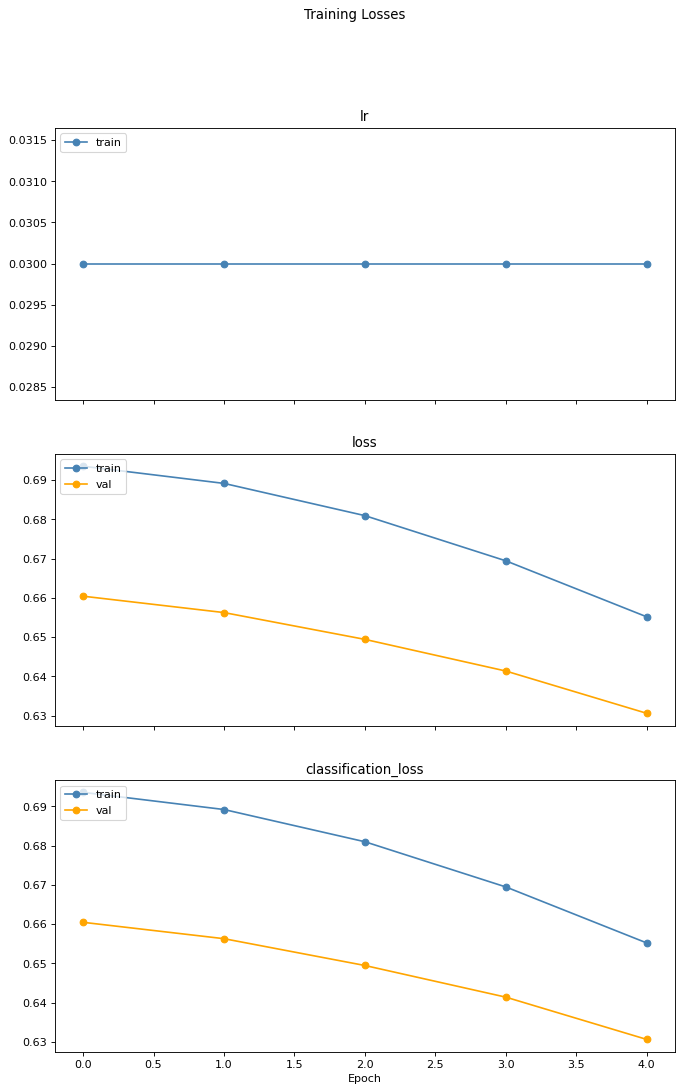

========================================For Training [chexpert]========================================
ImageClassificationArgs(name='chexpert', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, early_stopping_patience=10, warmup_epoch=0)
REFLACXCheXpertDatasetArgs(image_size=128, label_cols=['Atelectasis_chexpert', 'Cardiomegaly_chexpert', 'Consolidation_chexpert', 'Edema_chexpert', 'Enlarged Cardiomediastinum_chexpert', 'Fracture_chexpert', 'Lung Lesion_chexpert', 'Lung Opacity_chexpert', 'No Finding_chexpert', 'Pleural Effusion_chexpert', 'Pleural Other_chexpert', 'Pneumonia_chexpert', 'Pneumothorax_chexpert', 'Support Devices_chexpert'])
ResNetClassifierArgs(name='imagenet', weights='imagenet', cl_model_name=None, trainable_backbone_layers=3)

Best model has been saved to: [chexpert_imagenet_f1_0_0000_precision_0_0000_accuracy_0_8471_recall_0_0000_auc_0_4966_epoch5_10-03-2023 02-48-41]
The final model has been saved to: [chexpert_imagenet_f1_0_0000_precisio

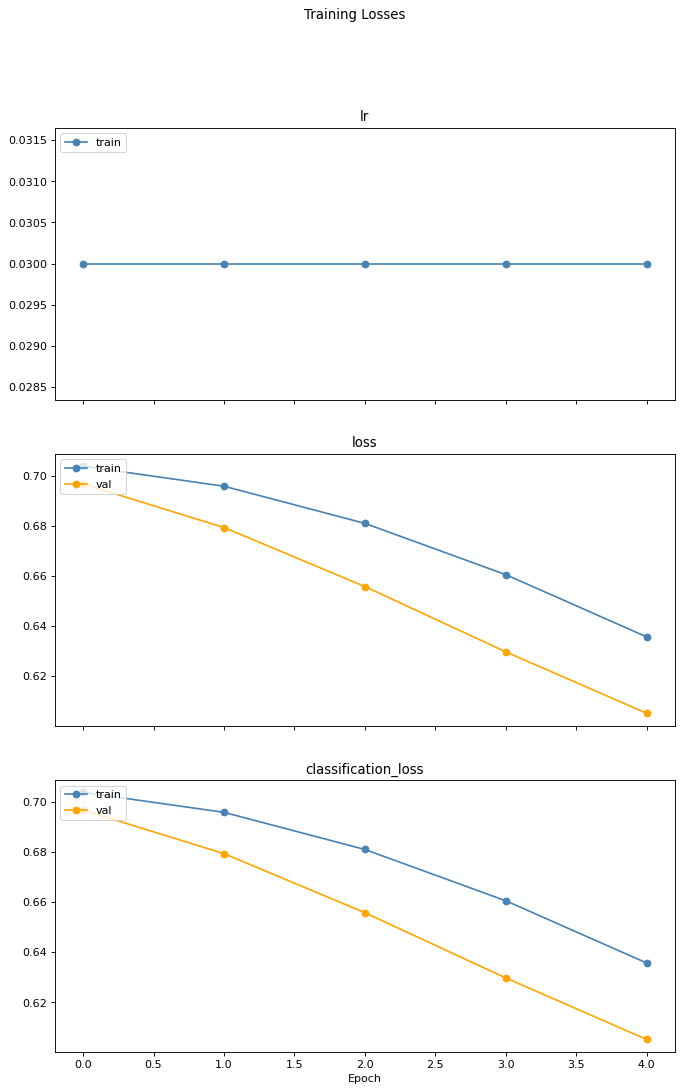

========================================For Training [chexpert]========================================
ImageClassificationArgs(name='chexpert', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, early_stopping_patience=10, warmup_epoch=0)
REFLACXCheXpertDatasetArgs(image_size=128, label_cols=['Atelectasis_chexpert', 'Cardiomegaly_chexpert', 'Consolidation_chexpert', 'Edema_chexpert', 'Enlarged Cardiomediastinum_chexpert', 'Fracture_chexpert', 'Lung Lesion_chexpert', 'Lung Opacity_chexpert', 'No Finding_chexpert', 'Pleural Effusion_chexpert', 'Pleural Other_chexpert', 'Pneumonia_chexpert', 'Pneumothorax_chexpert', 'Support Devices_chexpert'])
ResNetClassifierArgs(name='random', weights=None, cl_model_name=None, trainable_backbone_layers=5)

Best model has been saved to: [chexpert_random_f1_0_0000_precision_0_0000_accuracy_0_8529_recall_0_0000_auc_0_5000_epoch5_10-03-2023 02-49-18]
The final model has been saved to: [chexpert_random_f1_0_0000_precision_0_0000_acc

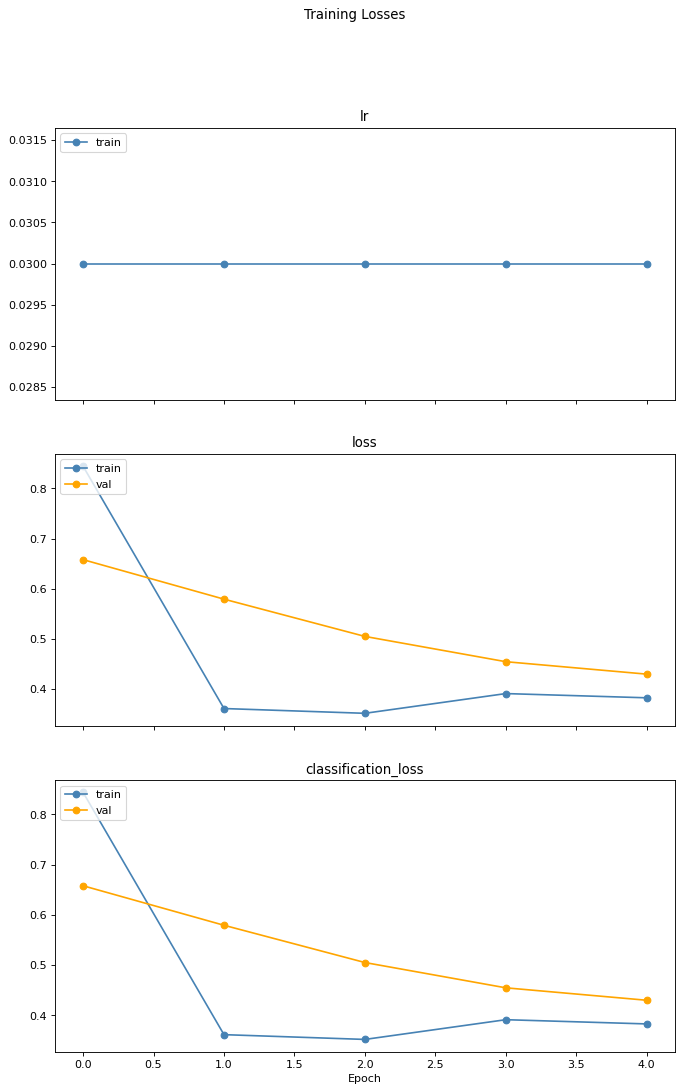

In [6]:
for t in train_infos :
    print(t)
    plot_losses(
        t.train_losses,
        t.val_losses,
    )

In [7]:
# Evaluate all train_infos on the best
from utils.checkpoint import load_checkpoints

for t in train_infos:

    train_info, cp = load_checkpoints(t.best_val_loss_model_path, device)
    config = train_info.config

    backbone = resnet50(weights=None)
    model = MultiBinaryClassificationModel(backbone)
    model.setup_last_layer(len(config.dataset.label_cols))
    model.to(device)
    model.load_state_dict(cp["model"])
    model.eval()

    dataset_args = {
        "df_path": os.path.join('spreadsheets', "reflacx.csv"),
        "mimic_eye_path": d_path.MIMIC_EYE_PATH,
        "image_size": config.dataset.image_size,
        "label_cols": config.dataset.label_cols,
    }

    _, _, test_dataset = get_datasets(
        dataset_args=dataset_args,
        dataset_class=REFLACXCheXpertDataset,
    )

    _, _, test_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        test_dataset,
        batch_size=config.training.batch_size,
        drop_last=False,
    )

    _, test_evaluator = evaluate(
            model=model,
            data_loader=test_dataloader,
            device=device,
            evaluator=ClassificationEvaluator(),
        )
    
    
    print(t)
    print(test_evaluator.get_performance())

    with open(os.path.join('checkpoints',t.best_val_loss_model_path, 'performance.txt'), 'w') as f:
        f.write(str(t) +"\n"+ "Best: \n" +str(test_evaluator.get_performance()))

Test:  [0/1]  eta: 0:00:04  model_time: 1.6224 (1.6224)  evaluator_time: 0.0000 (0.0000)  loss: 0.6680 (0.6680)  classification_loss: 0.6680 (0.6680)  time: 4.5914  data: 2.9659  max mem: 0
Test: Total time: 0:00:04 (4.5914 s / it)
Averaged stats: model_time: 1.6224 (1.6224)  evaluator_time: 0.0000 (0.0000)  loss: 0.6680 (0.6680)  classification_loss: 0.6680 (0.6680)
========================================For Training [chexpert]========================================
ImageClassificationArgs(name='chexpert', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, early_stopping_patience=10, warmup_epoch=0)
REFLACXCheXpertDatasetArgs(image_size=128, label_cols=['Atelectasis_chexpert', 'Cardiomegaly_chexpert', 'Consolidation_chexpert', 'Edema_chexpert', 'Enlarged Cardiomediastinum_chexpert', 'Fracture_chexpert', 'Lung Lesion_chexpert', 'Lung Opacity_chexpert', 'No Finding_chexpert', 'Pleural Effusion_chexpert', 'Pleural Other_chexpert', 'Pneumonia_chexpert', 'Pneumoth

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test:  [0/1]  eta: 0:00:04  model_time: 1.6224 (1.6224)  evaluator_time: 0.0000 (0.0000)  loss: 0.6324 (0.6324)  classification_loss: 0.6324 (0.6324)  time: 4.5907  data: 2.9663  max mem: 0
Test: Total time: 0:00:04 (4.5917 s / it)
Averaged stats: model_time: 1.6224 (1.6224)  evaluator_time: 0.0000 (0.0000)  loss: 0.6324 (0.6324)  classification_loss: 0.6324 (0.6324)
========================================For Training [chexpert]========================================
ImageClassificationArgs(name='chexpert', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, early_stopping_patience=10, warmup_epoch=0)
REFLACXCheXpertDatasetArgs(image_size=128, label_cols=['Atelectasis_chexpert', 'Cardiomegaly_chexpert', 'Consolidation_chexpert', 'Edema_chexpert', 'Enlarged Cardiomediastinum_chexpert', 'Fracture_chexpert', 'Lung Lesion_chexpert', 'Lung Opacity_chexpert', 'No Finding_chexpert', 'Pleural Effusion_chexpert', 'Pleural Other_chexpert', 'Pneumonia_chexpert', 'Pneumoth

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test:  [0/1]  eta: 0:00:04  model_time: 1.6179 (1.6179)  evaluator_time: 0.0000 (0.0000)  loss: 0.6053 (0.6053)  classification_loss: 0.6053 (0.6053)  time: 4.6044  data: 2.9846  max mem: 0
Test: Total time: 0:00:04 (4.6054 s / it)
Averaged stats: model_time: 1.6179 (1.6179)  evaluator_time: 0.0000 (0.0000)  loss: 0.6053 (0.6053)  classification_loss: 0.6053 (0.6053)
========================================For Training [chexpert]========================================
ImageClassificationArgs(name='chexpert', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, early_stopping_patience=10, warmup_epoch=0)
REFLACXCheXpertDatasetArgs(image_size=128, label_cols=['Atelectasis_chexpert', 'Cardiomegaly_chexpert', 'Consolidation_chexpert', 'Edema_chexpert', 'Enlarged Cardiomediastinum_chexpert', 'Fracture_chexpert', 'Lung Lesion_chexpert', 'Lung Opacity_chexpert', 'No Finding_chexpert', 'Pleural Effusion_chexpert', 'Pleural Other_chexpert', 'Pneumonia_chexpert', 'Pneumoth

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
